# Raw Signal Backtest

This notebook will examine trading the spread of each PCs as tradable signal for each Treasury Future. The majority of this notebook will focus on the performance of each signal with respect to each Treasury future. <br>
All returns and performance stats are expressed in basis points 

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from DataPreprocess import InflationPCA

## Signal Performance

In this case apply the signal to each Treausry to trade it. There isn't a presumption of which way to trade the signal. In this case just assume a static position (buy if positive, sell if negative or vice-versa). It isn't intuitive why a signal should be traded one way or the other. What is evident is that the performance is greatly positive if one way and another. Although this method is completely accurate, later a more formalized model will be introduced via OLS and then test whether how likely it is that the signal can be traded wrong. 

In [3]:
def get_signal_performance() -> pd.DataFrame: 
    
    df_tsy = (InflationPCA().get_tsy_fut().assign(
        security = lambda x: x.security.str.split(" ").str[0])
        [["date", "security", "PX_bps"]])

    df_combined = (InflationPCA().pca_signal()[
        ["date", "input_val", "variable", "lag_spread"]].
        merge(right = df_tsy, how = "inner", on = ["date"]).
        assign(
            signal_bps = lambda x: -np.sign(x.lag_spread) * x.PX_bps,
            input_val  = lambda x: np.where(x.input_val == "log_value", "Log", "Raw")))
    
    return df_combined

df_signal_perf = get_signal_performance()

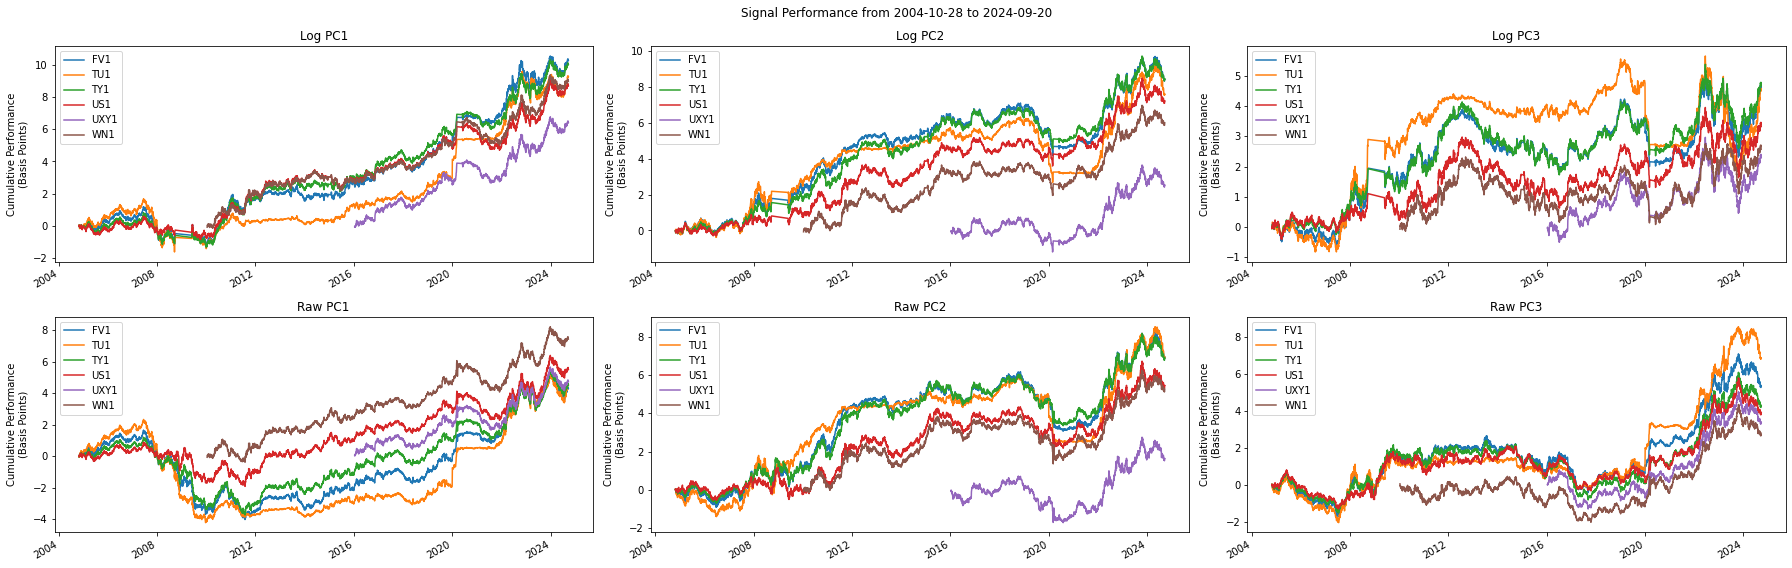

In [4]:
def plot_singal_performance(df_combined: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df_combined.assign(
        group_var = lambda x: x.input_val + " " + x.variable))

    variables = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (25,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_plot.query(
            "group_var == @variable")
            [["date", "signal_bps", "security"]].
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                title  = variable,
                xlabel = "",
                ylabel = "Cumulative Performance\n(Basis Points)"))

    fig.suptitle("Signal Performance from {} to {}".format(
        df_plot.date.min().date(),
        df_plot.date.max().date()))
    
    plt.tight_layout()
    
plot_singal_performance(df_signal_perf)

In [5]:
def get_sharpe(df_combined: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_combined[
        ["input_val", "variable", "security", "signal_bps"]].
        groupby(["input_val", "variable", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = get_sharpe(df_signal_perf)

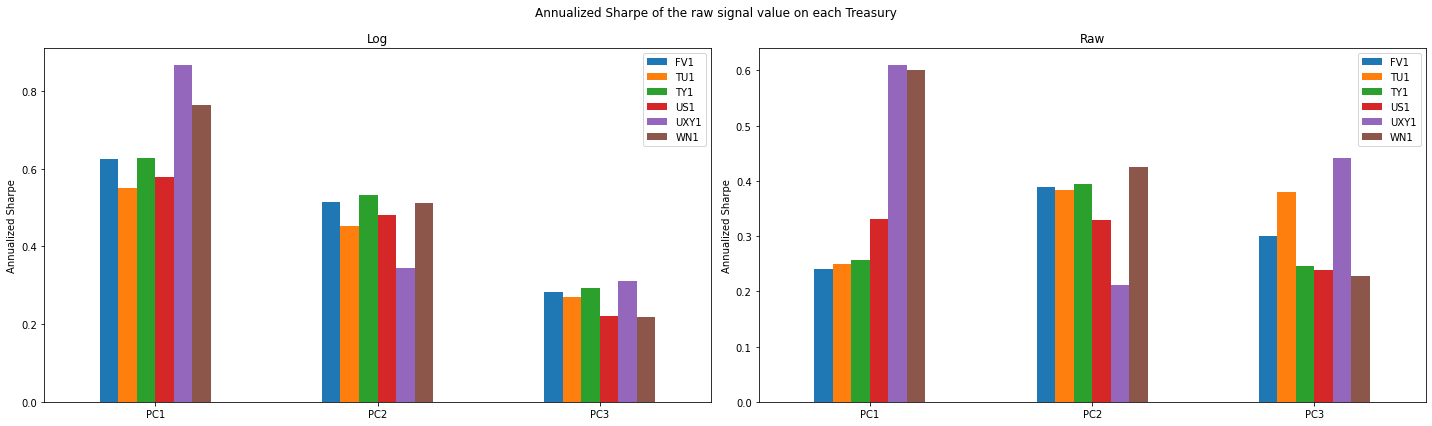

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    variables = df_sharpe.input_val.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()): 

        (df_sharpe.query(
            "input_val == @variable")
            [["variable", "security", "sharpe"]].
            rename(columns = {"security": ""}).
            pivot(index = "variable", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = variable))

    fig.suptitle("Annualized Sharpe of the raw signal value on each Treasury")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

This is an absolute sharpe measurement. Alhtough without looking the sharpes are reasonable for medium-speed Treasury Futures and outperform their underlying securities. In this case that needs to be tested as well.

In [7]:
def get_sharpe_spread(df_signal_perf: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe_spread = (df_signal_perf.drop(
        columns = ["lag_spread"]).
        rename(columns = {"variable": "pc"}).
        melt(id_vars = ["date", "input_val", "pc", "security"]).
        drop(columns = ["date"]).
        groupby(["input_val", "variable", "pc", "security"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["input_val", "variable", "pc", "security", "sharpe"]].
        pivot(index = ["input_val", "pc", "security"], columns = "variable", values = "sharpe").
        assign(sharpe_spread = lambda x: x.signal_bps - x.PX_bps).
        reset_index().
        drop(columns = ["PX_bps", "signal_bps"]))
    
    return df_sharpe_spread

df_sharpe_spread = get_sharpe_spread(df_signal_perf)

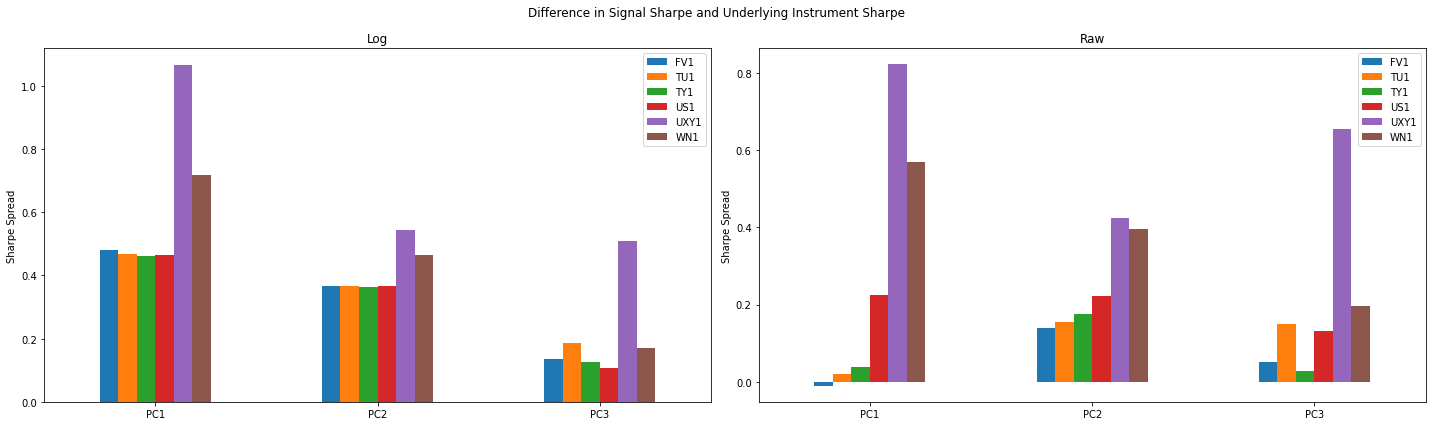

In [8]:
def plot_sharpe_spread(df_sharpe_spread: pd.DataFrame) -> plt.Figure:
    
    variables = df_sharpe_spread.input_val.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_sharpe_spread.query(
            "input_val == @variable")
            [["pc", "security", "sharpe_spread"]].
            rename(columns = {"security": ""}).
            pivot(index = "pc", columns = "", values = "sharpe_spread").
            plot(
                ax     = ax,
                kind   = "bar",
                title  = variable,
                ylabel = "Sharpe Spread",
                xlabel = "",
                rot    = 0))

    fig.suptitle("Difference in Signal Sharpe and Underlying Instrument Sharpe")
    plt.tight_layout()
    
plot_sharpe_spread(df_sharpe_spread)

UXY seem to have a strong outperformance but it likely stems from the contract being created in 2016 during a time of one interest rate regime. 

## Signal Attributes

Start by taking the cross-correlation of the performance. In this case rather than plotting the correlation matrix per each PC and inputted value (6 matrices), just take the average cross-correlation. 

In [9]:
def _get_avg_cross_correlation(df: pd.DataFrame) -> pd.DataFrame: 
    
    mean_val = (df[
        ["date", "security", "signal_bps"]].
        pivot(index = "date", columns = "security", values = "signal_bps").
        corr().
        reset_index().
        rename(columns = {"security": "security1"}).
        melt(id_vars = "security1").
        query("security1 != security").
        value.
        mean())
    
    return mean_val

def get_avg_cross_correlation(df_signal_perf: pd.DataFrame) -> pd.DataFrame: 

    df_cross_correlation = (df_signal_perf.assign(
        group_var = lambda x: x.input_val + " " + x.variable)
        [["date", "group_var", "security", "signal_bps"]].
        groupby("group_var").
        apply(_get_avg_cross_correlation).
        to_frame(name = "cross_correlation").
        reset_index())
    
    return df_cross_correlation

df_cross_correlation = get_avg_cross_correlation(df_signal_perf)

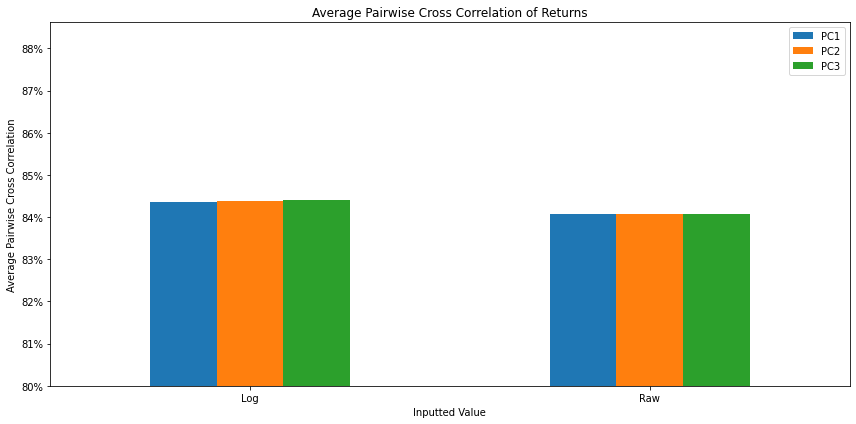

In [15]:
def plot_avg_cross_correlation(df_cross_correlation: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_cross_correlation.assign(
        input_val = lambda x: x.group_var.str.split(" ").str[0],
        pc        = lambda x: x.group_var.str.split(" ").str[1]).
        drop(columns = ["group_var"]).
        rename(columns = {"pc": ""}).
        pivot(index = "input_val", columns = "", values = "cross_correlation").
        plot(
            ax     = axes,
            kind   = "bar",
            xlabel = "Inputted Value",
            rot    = 0,
            ylabel = "Average Pairwise Cross Correlation",
            title  = "Average Pairwise Cross Correlation of Returns"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    axes.set_ylim(0.8)
    
    plt.tight_layout()
    
plot_avg_cross_correlation(df_cross_correlation)